In [62]:
import pandas as pd
import numpy as np
# show max columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from utils.exploration import *
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss, roc_auc_score

## Read Data

In [16]:
df_raw = pd.read_csv('Data\SEER_Final_Data_vf1_cleaned.csv')

In [17]:
df = df_raw.copy()

In [18]:
display(df.head(3), df.shape)

,Patient ID,Histologic Type ICD-O-3,Year of diagnosis,Sex,Race,Radiation recode,Bone Metastasis,Brain Metastasis,Liver Metastasis,Lung Metastasis,T,N,M,Grouped Stage,Chemotherapy,Tumor Size,Surgery,Age,Survival Months,Survival Months Group
0,194350,0,2010,Female,Black,1,0,0,0,0,T4,N1,M1,IV,1,46,0,75-79 years,14,12-24 months
1,674026,0,2010,Female,White,0,0,0,0,0,T2,N2,M0,III,1,50,0,60-64 years,66,Over 24 months
2,462906,0,2010,Female,White,1,1,1,0,1,T4,N2,M1,IV,1,70,0,70-74 years,2,0-12 months


(28882, 20)

In [19]:
df['Survival Months'].describe()

count    28882.000000
mean         9.672876
std         11.455663
min          0.000000
25%          2.000000
50%          7.000000
75%         13.000000
max        128.000000
Name: Survival Months, dtype: float64

<Axes: >

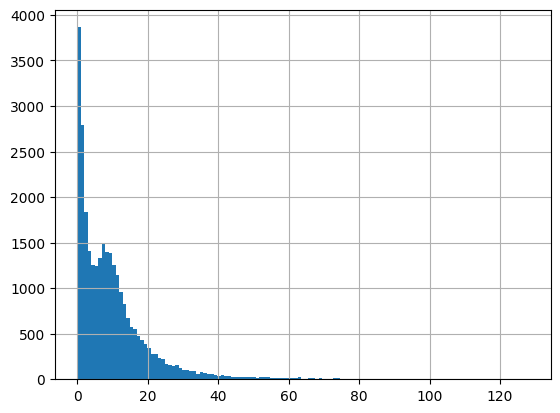

In [20]:
df['Survival Months'].hist(bins=129)

In [21]:
# Define the bins and labels
bins = [0, 6, 12, float('inf')]  
labels = ['0-6 months', '6-12 months', 'Over 12 months']

# Use pd.cut to create the new column
df['Grouped Survival Months'] = pd.cut(df['Survival Months'], bins=bins, labels=labels, right=False)

df['Survival Months Group'] = df['Grouped Survival Months'].astype('category')

# drop the old column
df.drop(columns='Grouped Survival Months', inplace=True)
df.drop(columns='Survival Months', inplace=True)

Counts and percentages of unique values in Survival Months Group:
                       Count  Percentage
Survival Months Group                   
0-6 months             12400   42.933315
Over 12 months          8493   29.405858
6-12 months             7989   27.660827


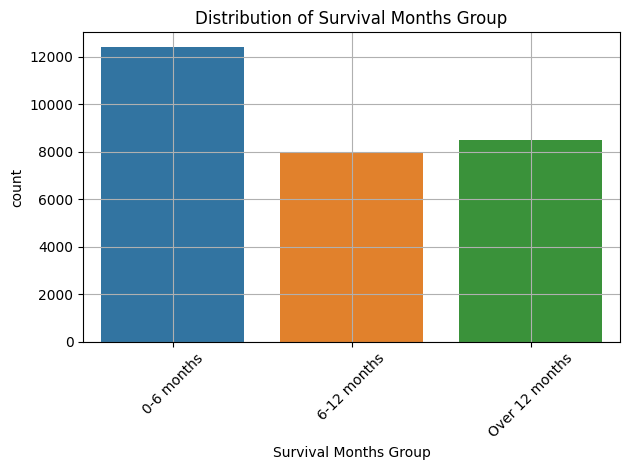

In [23]:
data_exploration(df, 'Survival Months Group')

## Data Preprocessing

In [24]:
# check missing values
df.isnull().sum()

Patient ID                 0
Histologic Type ICD-O-3    0
Year of diagnosis          0
Sex                        0
Race                       0
Radiation recode           0
Bone Metastasis            0
Brain Metastasis           0
Liver Metastasis           0
Lung Metastasis            0
T                          0
N                          0
M                          0
Grouped Stage              0
Chemotherapy               0
Tumor Size                 0
Surgery                    0
Age                        0
Survival Months Group      0
dtype: int64

In [25]:
# drop Year of diagnosis, Patient ID
df.drop(columns=['Year of diagnosis', 'Patient ID'], inplace=True)

In [30]:
df['Sex'].value_counts(dropna=False)

Sex
Female    14532
Male      14350
Name: count, dtype: int64

In [31]:
df['Sex'] = df['Sex'].map({'Female': 0, 'Male': 1})

In [32]:
df['Race'].value_counts(dropna=False) # we will do one hot encoding later

Race
White    25143
Black     2506
Other     1233
Name: count, dtype: int64

In [33]:
df['Radiation recode'].value_counts(dropna=False)

Radiation recode
0    15252
1    13630
Name: count, dtype: int64

In [34]:
df['Bone Metastasis'].value_counts(dropna=False)

Bone Metastasis
0    21610
1     7272
Name: count, dtype: int64

In [35]:
df['T'].value_counts(dropna=False) # we will do one hot encoding on T N M Stage later

T
T4    10560
T2     7306
T3     6364
T1     4652
Name: count, dtype: int64

In [36]:
df['Chemotherapy'].value_counts(dropna=False)

Chemotherapy
1    20599
0     8283
Name: count, dtype: int64

In [37]:
df['Surgery'].value_counts(dropna=False)

Surgery
0    22880
1     6002
Name: count, dtype: int64

In [38]:
df['Age'].value_counts(dropna=False)

Age
65-69 years    5599
70-74 years    5224
60-64 years    4583
75-79 years    4080
55-59 years    3241
80-84 years    2474
50-54 years    1669
85+ years      1246
45-49 years     580
20-44 years     186
Name: count, dtype: int64

In [39]:
df.dtypes

Histologic Type ICD-O-3       int64
Sex                           int64
Race                         object
Radiation recode              int64
Bone Metastasis               int64
Brain Metastasis              int64
Liver Metastasis              int64
Lung Metastasis               int64
T                            object
N                            object
M                            object
Grouped Stage                object
Chemotherapy                  int64
Tumor Size                    int64
Surgery                       int64
Age                          object
Survival Months Group      category
dtype: object

In [40]:
# a loop to convert all object columns to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [41]:
df.dtypes

Histologic Type ICD-O-3       int64
Sex                           int64
Race                       category
Radiation recode              int64
Bone Metastasis               int64
Brain Metastasis              int64
Liver Metastasis              int64
Lung Metastasis               int64
T                          category
N                          category
M                          category
Grouped Stage              category
Chemotherapy                  int64
Tumor Size                    int64
Surgery                       int64
Age                        category
Survival Months Group      category
dtype: object

## Modeling

| Models                         | Normalization of Numeric Columns? | Directly Handle Categorical Columns? | Linear Assumptions and Correlations? | Output Probabilities? |
|--------------------------------|-----------------------------------|-------------------------------------|--------------------------------------|-----------------------|
| Decision Trees and Random Forests | No                              | Yes                                 | No                                   | Yes                   |
| Gradient Boosting Machines (XGBoost, LightGBM) | Not necessary, but can be beneficial | Yes                             | No                                   | Yes                   |
| Support Vector Machines (SVM)  | Yes                              | No                                  | Yes (for linear kernel)              | Yes (with probability estimates enabled) |
| k-Nearest Neighbors (k-NN)     | Yes                              | No (requires one-hot or similar encoding) | No                               | Yes                   |
| Neural Networks                | Yes                              | No (requires one-hot or similar encoding) | No                               | Yes                   |
| Logistic Regression            | Yes                              | No (requires one-hot encoding)      | Yes                                  | Yes                   |


So for the sufficiency of the data, we can use the following models: 
- Decision Trees and Random Forests
- Gradient Boosting Machines (XGBoost, LightGBM)
- k-Nearest Neighbors (k-NN)
- Neural Networks

## Tree-based Models

In [42]:
df_t = df.copy()

In [43]:
from sklearn.preprocessing import LabelEncoder

# label encoding the Survival Months Group
smg_le = LabelEncoder()
df_t['Survival Months Group'] = smg_le.fit_transform(df_t['Survival Months Group'])

# show the mapping
dict(zip(smg_le.classes_, smg_le.transform(smg_le.classes_)))

{'0-6 months': 0, '6-12 months': 1, 'Over 12 months': 2}

In [49]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X = df_t.drop(columns='Survival Months Group')
y = df_t['Survival Months Group']

categorical_features = [col for col in X.columns if X[col].dtype == 'category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# check the shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'Catgorical features: {categorical_features}')

(23105, 16) (5777, 16) (23105,) (5777,)
Catgorical features: ['Race', 'T', 'N', 'M', 'Grouped Stage', 'Age']


### Decision Tree

In [51]:
# one hot encoding for categorical variables only
from sklearn.preprocessing import OneHotEncoder

X_train_ohe= pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# loop to change boolean columns to int
for col in X_train_ohe.columns:
    if X_train_ohe[col].dtype == 'bool':
        X_train_ohe[col] = X_train_ohe[col].astype('int')
        X_test_ohe[col] = X_test_ohe[col].astype('int')

for col in X_test_ohe.columns:
    if X_test_ohe[col].dtype == 'bool':
        X_train_ohe[col] = X_train_ohe[col].astype('int')
        X_test_ohe[col] = X_test_ohe[col].astype('int')

# check the shape
print(X_train_ohe.shape, X_test_ohe.shape, y_train.shape, y_test.shape)

(23105, 31) (5777, 31) (23105,) (5777,)


In [53]:
from sklearn.metrics import fbeta_score, make_scorer
# Custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


# Define the parameter grid
param_dist = {
    'max_depth': range(3, 21),
    'min_samples_leaf': range(5, 400),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': np.linspace(0, 1, 100)
}

# Decision Tree classifier
dt = DecisionTreeClassifier()

# Random search with cross-validation
random_search = RandomizedSearchCV(dt, param_dist, n_iter=100, scoring=f2_scorer, cv=10, random_state=123)

# Fit the model
random_search.fit(X_train_ohe, y_train)


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'ccp_alpha': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222...
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(3, 21),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': range(5, 400)},
                   random_state=123,
                   scoring=make_scorer(fbeta_score, beta=2, average=weighted))

In [56]:
# print the best parameters
print(random_search.best_params_)

{'min_samples_leaf': 52, 'max_features': 'sqrt', 'max_depth': 19, 'criterion': 'entropy', 'ccp_alpha': 0.0}


In [60]:
# predict on the test set
y_pred = random_search.predict(X_test_ohe)

# print the train and test scores, confusion matrix, classification report
print(f'Train score: {random_search.best_score_:.4f}')
print(f'Test score: {random_search.score(X_test_ohe, y_test):.4f}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train score: 0.5541
Test score: 0.5603
[[1784  356  340]
 [ 559  444  595]
 [ 364  291 1044]]
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      2480
           1       0.41      0.28      0.33      1598
           2       0.53      0.61      0.57      1699

    accuracy                           0.57      5777
   macro avg       0.53      0.54      0.53      5777
weighted avg       0.55      0.57      0.55      5777



In [64]:
# print log loss and auc-roc score
y_pred_proba = random_search.predict_proba(X_test_ohe)
# Log Loss
print(f'Log loss: {log_loss(y_test, y_pred_proba):.4f}')

# AUC-ROC for Multiclass
# Binarize y_test for multiclass ROC AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # adjust classes as needed
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print(f'AUC-ROC score: {roc_auc:.4f}')

Log loss: 0.9203
AUC-ROC score: 0.7493


### LightGBM

In [65]:
from optuna.integration.lightgbm import LightGBMTunerCV as lgbtcv
from lightgbm import early_stopping
import optuna
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
from lightgbm import Dataset as lgbDataset
from sklearn.metrics import fbeta_score

In [66]:
# Define the custom F2 evaluation function
def lgb_f2_eval(preds, data):
    labels = data.get_label()
    preds = preds.reshape(len(np.unique(labels)), -1)
    preds = preds.argmax(axis=0)
    return 'lgb_f2_eval', -fbeta_score(labels, preds, beta=2, average='weighted'), False  # Return the negative F2 score


In [ ]:
# Parameters for LightGBM for multiclass classification
params = {
    "objective": "multiclass",  # Objective for multiclass classification
    "num_class": 3,  # Number of classes
    "metric": "multi_logloss",  # Use custom metric
    "boosting_type": "gbdt",
    "verbosity": -1,
}

# Create LightGBM dataset (assuming X1_a_train and y1_a_train are defined)
dtrain = lgbDataset(X_train, label=y_train, categorical_feature=categorical_features)

# Create an Optuna study object
study_auto_lgb = optuna.create_study(direction='minimize', study_name='LightGBM Tuner CV for Multiclass Classification')

# Perform cross-validation with Optuna
auto_lgb_tuner = lgbtcv(
    params=params, 
    train_set=dtrain,  
    num_boost_round=100,  # Number of boosting iterations
    nfold=10,  
    stratified=True,  # Perform stratified sampling
    seed=123,  # Fix random seed for reproducibility of cv
    optuna_seed=123,  # Fix random seed for reproducibility of optuna trials
    shuffle=True,  # Shuffle data before creating folds
    callbacks=[early_stopping(15)],
    study=study_auto_lgb,
    feval=lgb_f2_eval
)

auto_lgb_tuner.run()


In [74]:
import lightgbm as lgb
# print the best trial's parameters and fit model with the best parameters
print(f'Best trial parameters: {auto_lgb_tuner.best_params}')
print(f'Best score: {auto_lgb_tuner.best_score}')

# predict on the test set
auto_params = auto_lgb_tuner.best_params
auto_best_lgb_model = lgb.LGBMClassifier(**auto_params, random_state=123)
auto_best_lgb_model.fit(X_train, y_train, categorical_feature=categorical_features)

# print the train and test scores, confusion matrix, classification report
print(f'Train score: {auto_lgb_tuner.best_score}')
print(f'Test score: {fbeta_score(y_test, y_pred, beta=2, average="weighted")}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best trial parameters: {'objective': 'multiclass', 'num_class': 3, 'metric': 'multi_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0008398254425324348, 'lambda_l2': 0.00016989826159034577, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
Best score: 0.9709672691507738
Train score: 0.9709672691507738
Test score: 0.5602731822859333
[[1784  356  340]
 [ 559  444  595]
 [ 364  291 1044]]
              precision    recall  f1-score   support

           0       0.66      0.72      0.69      2480
           1       0.41      0.28      0.33      1598
           2       0.53      0.61      0.57      1699

    accuracy                           0.57      5777
   macro avg       0.53      0.54      0.53      5777
weighted avg       0.55      0.57      0.55      5777



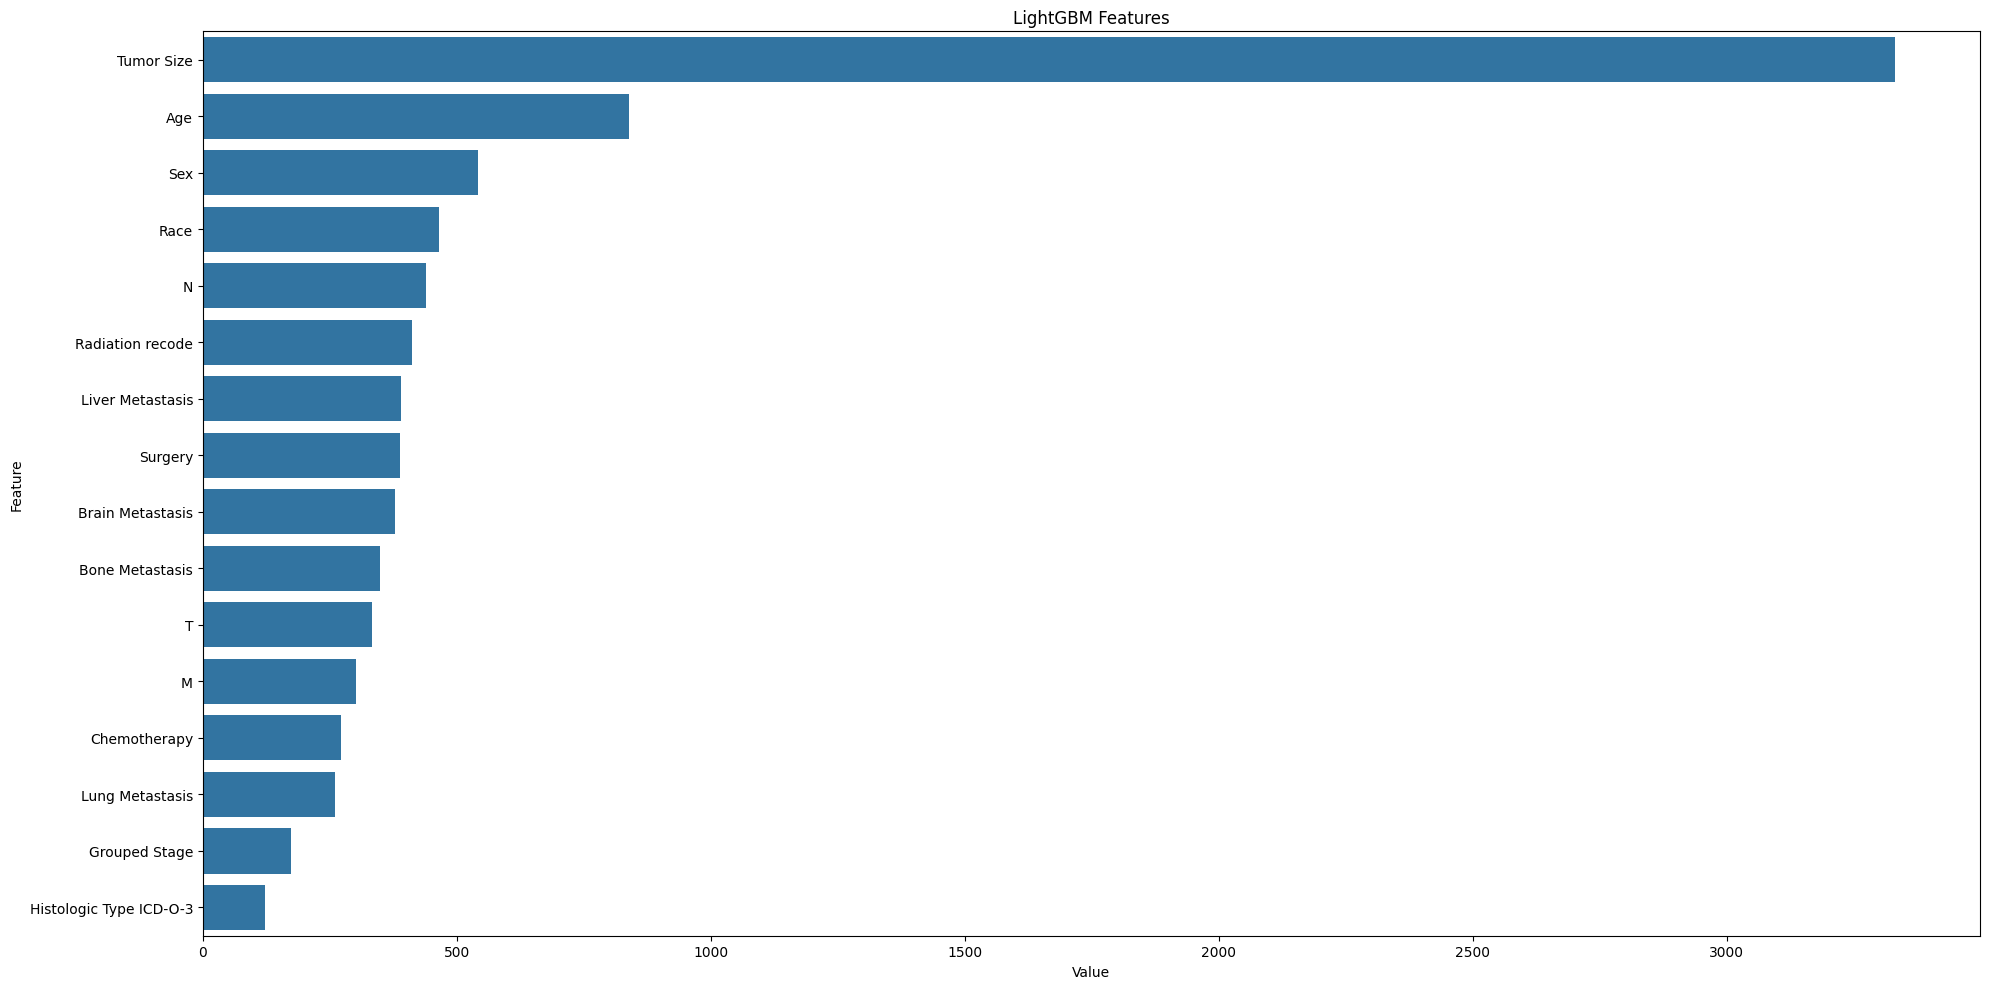

In [75]:
# plot feature importance sorted from highest to lowest
feature_imp = pd.DataFrame(sorted(zip(auto_best_lgb_model.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()